In [1]:
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

import pandas as pd
import os

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
os.getenv('MLFLOW_TRACKING_URI', 'No env')

'http://mlflow-service:5000'

In [3]:
mlflow.get_registry_uri()

'http://mlflow-service:5000'

In [4]:
def load_and_prepare_data():
    data = fetch_california_housing(as_frame=True)
    df = data.frame
    X = df.drop('MedHouseVal', axis=1)
    y = df['MedHouseVal']
    
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

    print('Dataset has been splitted successfully!')

    return X_train, X_test, X_val, y_train, y_test, y_val

In [5]:
def run_experiment():
    experiment_name = 'larchenkov-mihail'
    experiment = mlflow.get_experiment_by_name(experiment_name)

    if experiment is None:
        experiment_id = mlflow.create_experiment(name=experiment_name)
    else:
        experiment_id = experiment.experiment_id

    X_train, X_test, X_val, y_train, y_test, y_val = load_and_prepare_data()

    models = {
        'LinearRegression': LinearRegression(),
        'DecisionTree': DecisionTreeRegressor(),
        'RandomForest': RandomForestRegressor()
    }

    with mlflow.start_run(run_name='garotar', experiment_id=experiment_id, description='parent') as parent_run:
        for model_name, model in models.items():
            with mlflow.start_run(run_name=model_name, experiment_id=experiment_id, nested=True) as child_run:

                model.fit(pd.DataFrame(X_train), y_train)
                prediction = model.predict(X_test)

                eval_df = pd.DataFrame(X_val).copy()
                eval_df['target'] = y_val

                signature = infer_signature(X_test, prediction)
                model_info = mlflow.sklearn.log_model(model, model_name, signature=signature)

                mlflow.evaluate(
                    model=model_info.model_uri,
                    data=eval_df,
                    targets='target',
                    model_type='regressor',
                    evaluators=['default'],
                )
                
                print(f'Model {model_name} has been fitted and logged successfully!')

In [6]:
run_experiment()

Dataset has been splitted successfully!


2024/10/13 17:25:56 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/10/13 17:25:56 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/10/13 17:25:56 WARNING mlflow.models.evaluation.default_evaluator: SHAP or matplotlib package is not installed, so model explainability insights will not be logged.
2024/10/13 17:25:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run LinearRegression at: http://mlflow-service:5000/#/experiments/762235355836888381/runs/19c927a5fc554a39866a688d473defc7.
2024/10/13 17:25:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-service:5000/#/experiments/762235355836888381.


Model LinearRegression has been fitted and logged successfully!


2024/10/13 17:26:01 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/10/13 17:26:01 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/10/13 17:26:01 WARNING mlflow.models.evaluation.default_evaluator: SHAP or matplotlib package is not installed, so model explainability insights will not be logged.
2024/10/13 17:26:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run DecisionTree at: http://mlflow-service:5000/#/experiments/762235355836888381/runs/d1eef8db11934098ae82d481d3a7ab64.
2024/10/13 17:26:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-service:5000/#/experiments/762235355836888381.


Model DecisionTree has been fitted and logged successfully!


2024/10/13 17:26:53 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/10/13 17:26:53 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/10/13 17:26:53 WARNING mlflow.models.evaluation.default_evaluator: SHAP or matplotlib package is not installed, so model explainability insights will not be logged.
2024/10/13 17:26:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest at: http://mlflow-service:5000/#/experiments/762235355836888381/runs/f1978cffb2294ca497fc2d6d7809c402.
2024/10/13 17:26:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://mlflow-service:5000/#/experiments/762235355836888381.
2024/10/13 17:26:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run garotar at: http://mlflow-service:5000/#/experiments/762235355836888381/runs/a21e7caaf1094a669753f3430f009ce1.
2024/10/13 17:26:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://ml

Model RandomForest has been fitted and logged successfully!


In [8]:
rf_example = mlflow.sklearn.load_model(model_uri='s3://larchenkov-mlflow-artifacts/mlflow/762235355836888381/f1978cffb2294ca497fc2d6d7809c402/artifacts/RandomForest')

In [9]:
_, X_test, X_val, _, y_test, y_val = load_and_prepare_data()

Dataset has been splitted successfully!


In [10]:
rf_prediction = rf_example.predict(X_val)
rf_prediction

array([0.51273  , 3.7036931, 0.62224  , ..., 1.21688  , 1.90181  ,
       2.46507  ])

In [11]:
from sklearn.metrics import r2_score, mean_squared_error

print(f'r2: {r2_score(y_val, rf_prediction)} \nmse: {mean_squared_error(y_val, rf_prediction)}')

r2: 0.8029560423881712 
mse: 0.2539464280201989


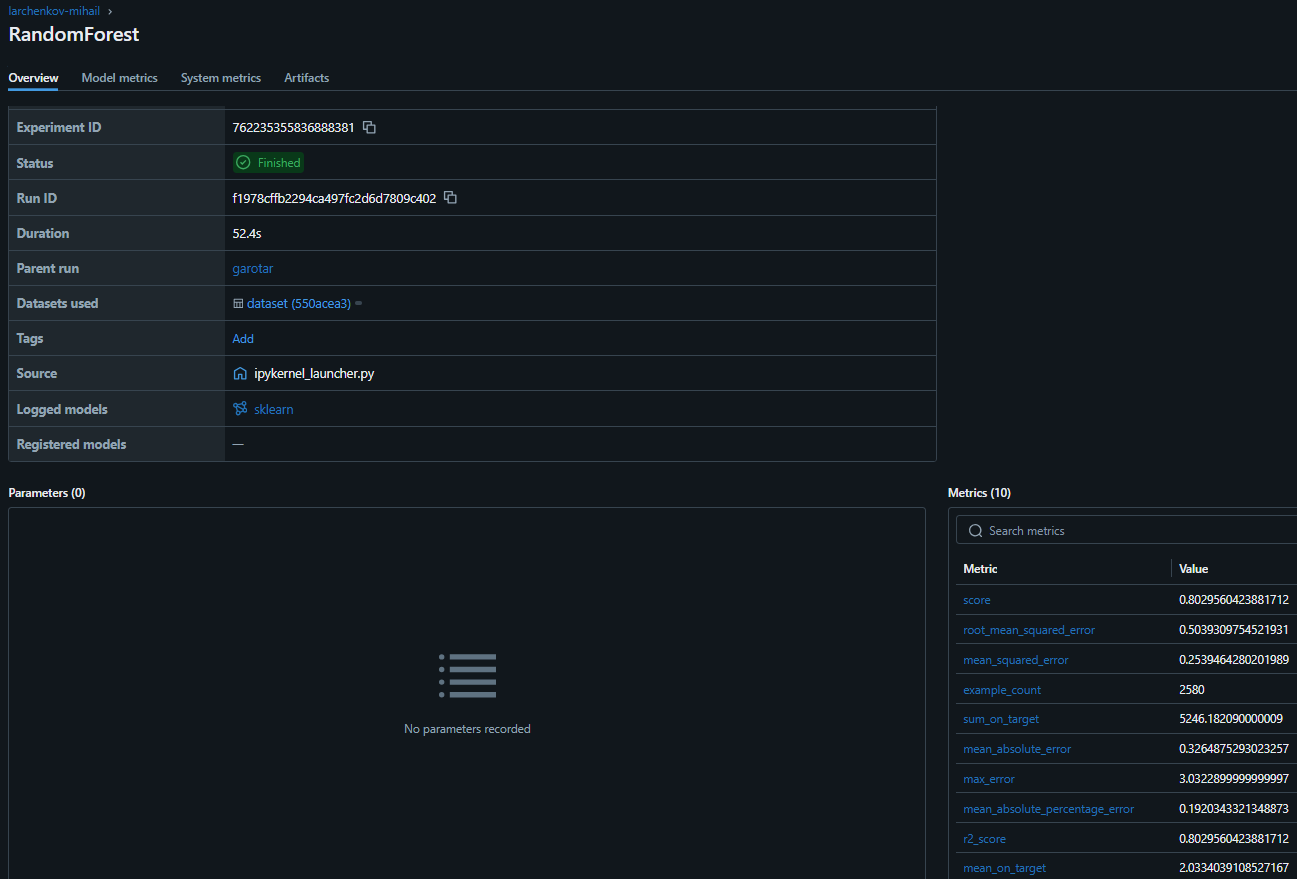